# Calculating Standardized Precipitation Index (SPI) with GEE and XArray

## **Overview**

This is a demonstration of how we can use the [XEE](https://github.com/google/Xee) package to extract a precipitation time-series images from Earth Engine and then use the [Climate Indicies](https://climate-indices.readthedocs.io/en/latest/) Python package to calculate SPI.

## Setup and Data Download

The following blocks of code will install the required packages and download the datasets to your Colab environment.

In [ ]:
%%capture
if 'google.colab' in str(get_ipython()):
    !pip install climate-indices xee rioxarray

In [ ]:
import ee
import xarray as xr
import rioxarray as rxr
import climate_indices
from climate_indices import indices
import matplotlib.pyplot as plt
import geopandas as gpd
import os
import datetime
import numpy as np

In [ ]:
data_folder = 'data'
output_folder = 'output'

if not os.path.exists(data_folder):
    os.mkdir(data_folder)
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

In [ ]:
def download(url):
    filename = os.path.join(data_folder, os.path.basename(url))
    if not os.path.exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

data_url = 'https://naciscdn.org/naturalearth/10m/cultural/'


shapefile = 'ne_10m_admin_0_countries_ind.zip'

download(data_url + shapefile)

Initialize EE with the [High-Volume EndPoint](https://developers.google.com/earth-engine/guides/processing_environments#high-volume_endpoint) recommended to be used with XEE.

In [ ]:
cloud_project = 'spatialthoughts'

try:
    ee.Initialize(project=cloud_project, opt_url='https://earthengine-highvolume.googleapis.com')
except:
    ee.Authenticate()
    ee.Initialize(project=cloud_project, opt_url='https://earthengine-highvolume.googleapis.com')

## Procedure

Load the Natural Earth Admin0 boundaries and extract the polygon for India.

In [ ]:
shapefile_path = os.path.join(data_folder, shapefile)
gdf = gpd.read_file(shapefile_path, encoding='utf-8')
country = gdf[gdf['SOV_A3'] == 'IND']

Now we have an ImageCollection that we want to get it as a XArray Dataset. We define the region of interest and extract the ImageCollection using the 'ee' engine.

In [ ]:
era5 = ee.ImageCollection('ECMWF/ERA5_LAND/MONTHLY_AGGR')
filtered = era5 \
  .filter(ee.Filter.date('2000-01-01', '2025-01-01')) \
  .select('total_precipitation_sum')

geometry = country.geometry.union_all()
bounds = geometry.bounds

ds = xr.open_dataset(
    filtered,
    engine='ee',
    projection=filtered.first().select(0).projection(),
    geometry=bounds
)

The result is a XArray Dataset containing the image time-series.

In [ ]:
ds

Select the `total_precipitation_sum` variable. Many XArray functions require all the dimensions to be sorted in ascending order. Make sure `lat` and `lon` are sorted.

In [ ]:
da = ds.total_precipitation_sum
da = da.sortby(['lat', 'lon'])
da = da.fillna(0.0)
da

We now have a monthly precipitation time-series at each pixel. We can reformat the DataArray by grouping the time-series at each lat/lon.

In [ ]:
da_precip_groupby = da.stack(pixel=('lat', 'lon')).groupby('pixel')

Configure the SPI calculation.

In [ ]:
scale = 3
distribution = climate_indices.indices.Distribution.gamma
data_start_year = 2000
calibration_year_initial = 2000
calibration_year_final = 2024
periodicity = climate_indices.compute.Periodicity.monthly

def calculate_spi(group):
    spi_values = climate_indices.indices.spi(
        group.values,
        scale,
        distribution,
        data_start_year,
        calibration_year_initial,
        calibration_year_final,
        periodicity
    )
    return xr.DataArray(spi_values, coords={'time': group.time}, dims=['time'])

In [ ]:
%%time
# apply SPI to each `pixel`
da_spi = da_precip_groupby.apply(calculate_spi)

Unstack the array back into original dimensions.

In [ ]:
da_spi = da_spi.unstack('pixel')

## Visualize the Results

We use a faceted plot to visualize all months of a selected year.

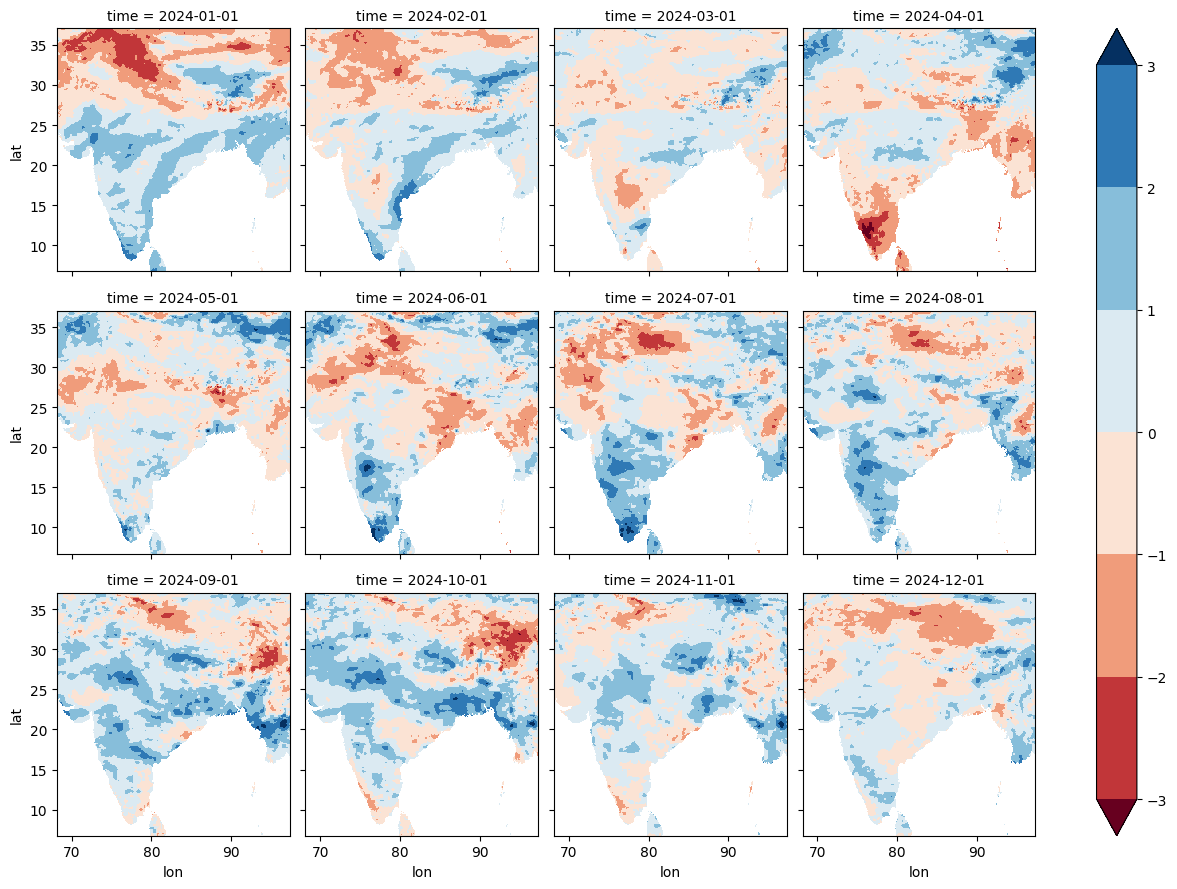

In [20]:
# select a year to visualize
selected = da_spi.sel(time='2024')

legend_levels = [-3,-2,-1,0,1,2,3]
selected.plot(cmap='RdBu', col='time', col_wrap=4, levels=legend_levels)
plt.show()

## Save Output as GeoTIFFs

We can use `rioxarray` to clip and save the resulting arrays as GeoTIFF files.

In [ ]:
# select a year to save
selected = da_spi.sel(time='2024')

In [ ]:
for time in selected.time.values:
    date_string = np.datetime_as_string(time, unit='M')
    image = selected.sel(time=time) \
      .rename({'lat': 'y', 'lon': 'x'}) \
      .transpose('y', 'x') \
      .rio.write_crs('EPSG:4326') \
      .rio.clip(country.geometry.values)
    output_file = f'{date_string}.tif'
    output_path = os.path.join(output_folder, output_file)
    image.rio.to_raster(output_path, driver='COG')
    print(f'Saved {output_path}')